# Feature extraction with interpreTS

In this tutorial, we show how you can use interpreTS instead of tsfel to extract features from time series and use them for classification.

In [65]:
from sys import platform

if platform == "linux" or platform == "linux2":
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip >/dev/null 2>&1
else:
    !pip install wget
    import wget

    wget.download("http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip")

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import interpreTS as it

sns.set()

# Unzip dataset
zip_ref = zipfile.ZipFile("UCI HAR Dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [67]:
x_train_sig = pd.DataFrame(np.loadtxt("UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt", dtype="float32")).stack().reset_index(name='value').drop(columns=['level_1', 'level_0'])
x_test_sig = pd.DataFrame(np.loadtxt("UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt", dtype="float32")).stack().reset_index(name='value').drop(columns=['level_1', 'level_0'])
y_test = np.loadtxt("UCI HAR Dataset/test/y_test.txt")
y_train = np.loadtxt("UCI HAR Dataset/train/y_train.txt")
activity_labels = np.array(pd.read_csv("UCI HAR Dataset/activity_labels.txt", header=None, delimiter=" "))[:, 1]
x_train_sig

,value
0,1.012817
1,1.022833
2,1.022028
3,1.017877
4,1.023680
...,...
941051,0.991497
941052,0.945067
941053,0.898095
941054,0.828372


# Extracting features

In [68]:
extractor = it.FeatureExtractor(window_size=128, stride=128)
train_features = extractor.extract_features(x_train_sig)
test_features = extractor.extract_features(x_test_sig)
train_features.head()

,length_value,mean_value,variance_value,stability_value,entropy_value,spikeness_value,seasonality_strength_value
0,128,1.019305,0.000003,0.940982,0.898926,-0.282135,0.045686
1,128,1.019448,0.000004,0.919031,0.911930,-0.400059,0.104132
2,128,1.019927,0.000008,0.888929,0.897870,-0.571735,0.049088
3,128,1.020349,0.000007,0.873804,0.862434,-0.820611,0.034890
4,128,1.020255,0.000004,0.900455,0.904267,-0.223113,0.147487


# Classification

In [69]:
selector = VarianceThreshold()
train_features = selector.fit_transform(train_features)
test_features = selector.transform(test_features)

scaler = preprocessing.StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [70]:
classifier = RandomForestClassifier()

classifier.fit(train_features, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(test_features)

# Get the classification report
print("Accuracy:", accuracy_score(y_test, y_test_predict))
print(classification_report(y_test, y_test_predict, target_names=activity_labels))

Accuracy: 0.7926705123854768
                    precision    recall  f1-score   support

           WALKING       0.78      0.94      0.85       496
  WALKING_UPSTAIRS       0.85      0.74      0.79       471
WALKING_DOWNSTAIRS       0.89      0.81      0.85       420
           SITTING       0.64      0.53      0.58       491
          STANDING       0.63      0.73      0.67       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.79      2947
         macro avg       0.80      0.79      0.79      2947
      weighted avg       0.80      0.79      0.79      2947



# Prediction visualization

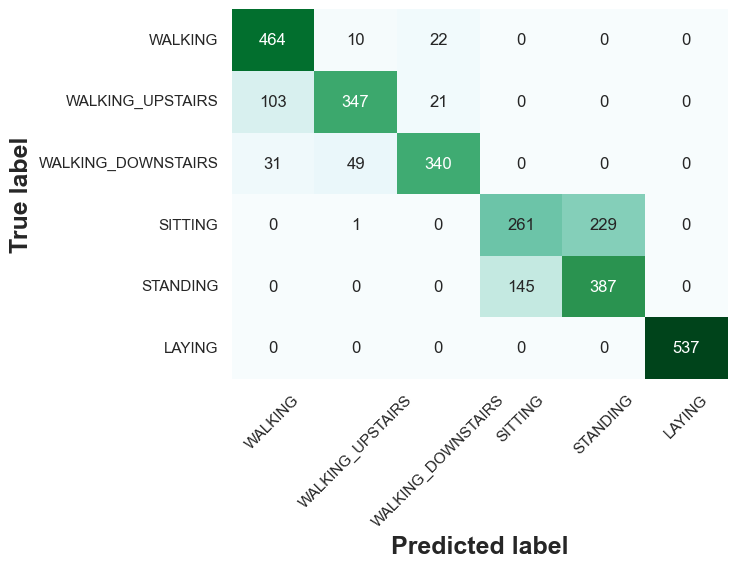

In [71]:
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax = sns.heatmap(df_cm, cbar=False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel("True label", fontweight="bold", fontsize=18)
plt.xlabel("Predicted label", fontweight="bold", fontsize=18)
bottom, top = ax.get_ylim()
plt.show()